# Project pipeline/strategy:

- write the problem statement; write executive summary/dreamboard; get yourself in mindset of dreaming this project successfully
- with that mindset, put myself in company's exec boardroom and understand which types of errors are more costly than others, and think about how I might quantify one miss over another miss; with that I have a ratio of cost; if one thing costs 2x as much, we want that to happen less(?) often; once I have that, can think about which metrics will help me get where I need to be before I do any modeling or feature engineering at all. It's like setting your alpha/statistically significant line in the sand before you do any science
- so which metrics might help you? Maybe changing the F1 to a different ratio; maybe other metrics that may be useful (lots of metrics on sklearn and above and beyond that you can use or custom make - e.g., take invidiaul indices (rows nad columns) of confusion matrix and drop them into total cost of doing business by plugging those numbers into a formula; so when you grid search, you can take those confusion matrices and say here are the costs of all the different various models
- then you can go back and think about feature engineering
    - if using cat boost, maybe do'nt need to think about one hot encoding; if using sklearn, need to do one hot encoding
- sklearn has whole section on doing feature selection; equivalent of doing z score on features, or weighted analysis on what features are important
- then once I have a robust dataset (full dataset and reduced); can throw both at things
- have all these models and evaluate all the variance based on cost of doing business
    - e.g., here are my best models - best KNN, best decsion tree, best random forest
    - then can say this was preliminary testing; then can say decided to focus on KNN and random forest doing different things - different size of trees, etc.
    - then after SVM, my best random forest was this and my best (?) was this;
    - then share why one beat the other
- ROC curve
- then end with: here is the ideal model; we would expect only 6% of time false positive, accuracy of xx (you can share accuracy but shouldn't be driving decision maker for project)

***What are people doing this time around that's different?***
- more data science, use more models, more time reading documentation of each model; grid search
- functioning with less chaos; instead of building models everywhere, work backwards - problem I want to solve, mindset of a PM

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

# make prettier plots
%config InlineBackend.figure_format = 'svg'

# imports that I don't have from Tony
from patsy import dmatrices, dmatrix
import re
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

seed = 5
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_json('/Users/laurenfinkelstein/Metis/Projects/Project 3/credit_payment_default/results-20190430-210539.json')

# EDA and data cleaning

In [ ]:
df.head()

In [ ]:
df.info()

In [13]:
# remove unecessary columns and reorder necessary columns

new_columns = ['id',  'default_payment_next_month', 'age', 'sex', 'marital_status', 'education_level',  
               'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
               'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
               'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
               'limit_balance']

model_data = df[new_columns]

In [14]:
model_data.head()

,id,default_payment_next_month,age,sex,marital_status,education_level,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance
0,242,0,39,1,2,1,47174,47974,48630,50803,30789,15874,0,0,0,0,0,0,1800,2000,3000,2000,2000,2000,50000
1,1822,0,29,2,2,1,48088,45980,44231,32489,26354,20221,0,0,0,0,0,0,2000,2010,3000,3000,3000,1000,110000
2,5046,0,36,1,2,1,78630,68921,46512,40335,37165,22156,0,0,0,2,0,0,10076,4018,14,2051,2000,0,270000
3,7227,0,45,1,1,1,58180,59134,61156,62377,63832,65099,0,0,0,0,0,0,2886,2908,2129,2354,2366,2291,130000
4,9183,0,24,1,2,1,42058,35340,22110,19837,19855,20151,0,0,0,0,0,0,1367,1606,692,709,721,692,50000


In [15]:
# figuring out what the different variables mean
# pay_0 etc. have additional labels other than labels described in GCP (e.g., 0, -1), but leave as is?

temp_columns = ['id',  'default_payment_next_month', 'age', 'sex', 'marital_status', 'education_level',  
               'bill_amt_1',
               'pay_0', 
               'pay_amt_1',
               'limit_balance']

df_temp = df[temp_columns]
df_temp.head()
# df_temp.pay_0.value_counts()

,id,default_payment_next_month,age,sex,marital_status,education_level,bill_amt_1,pay_0,pay_amt_1,limit_balance
0,242,0,39,1,2,1,47174,0,1800,50000
1,1822,0,29,2,2,1,48088,0,2000,110000
2,5046,0,36,1,2,1,78630,0,10076,270000
3,7227,0,45,1,1,1,58180,0,2886,130000
4,9183,0,24,1,2,1,42058,0,1367,50000


In [16]:
# is there only one entry per unique user id?
# answer = no duplicates

new = model_data.drop_duplicates()
new.count()
# df_filtered.groupby('id').count()
# df_filtered['id'].value_counts() > 1

id                            2965
default_payment_next_month    2965
age                           2965
sex                           2965
marital_status                2965
education_level               2965
bill_amt_1                    2965
bill_amt_2                    2965
bill_amt_3                    2965
bill_amt_4                    2965
bill_amt_5                    2965
bill_amt_6                    2965
pay_0                         2965
pay_2                         2965
pay_3                         2965
pay_4                         2965
pay_5                         2965
pay_6                         2965
pay_amt_1                     2965
pay_amt_2                     2965
pay_amt_3                     2965
pay_amt_4                     2965
pay_amt_5                     2965
pay_amt_6                     2965
limit_balance                 2965
dtype: int64

# EDA

KeyError: "None of [Index([(39, 29, 36, 45, 24, 29, 38, 42, 41, 24, 27, 37, 52, 24, 41, 42, 34, 23, 25, 29, 35, 43, 22, 31, 23, 28, 32, 29, 25, 27, 29, 26, 25, 34, 26, 22, 24, 31, 45, 49, 36, 33, 26, 29, 43, 52, 43, 60, 26, 27, 46, 35, 58, 22, 37, 28, 29, 31, 30, 39, 48, 34, 23, 41, 37, 36, 26, 33, 32, 41, 24, 32, 30, 24, 24, 27, 58, 36, 26, 36, 34, 30, 30, 31, 29, 45, 52, 38, 27, 36, 25, 32, 41, 50, 24, 40, 23, 26, 62, 45, ...), (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...)], dtype='object')] are in the [columns]"

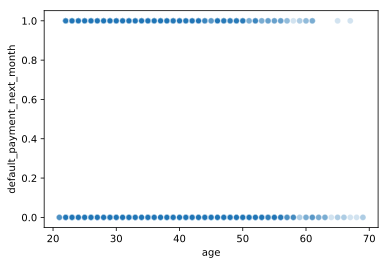

In [17]:
# copied from Tony but unsure what x variable I should use?

var_x_str = model_data['age']
var_y_str = model_data['default_payment_next_month']
sns.scatterplot(x=var_x_str, y=var_y_str, data=model_data, alpha=0.2);
print(model_data[[var_x_str, var_y_str]].corr())

# Balance classes

In [5]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

# prints confusion matrix as a heatmap which is nicer to visaulize

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [6]:
# target count to determine if classes are imbalanced

target_count = df_filtered.default_payment_next_month.value_counts()

# print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 2330
Class 1: 635
Proportion: 3.67 : 1
Percentage of Majority Class: 78.58000000000001


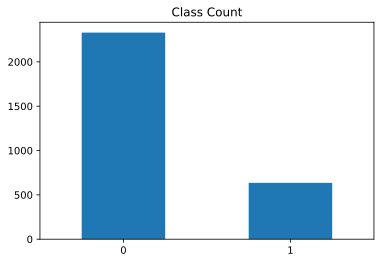

In [7]:
target_count.plot(kind='bar', title='Class Count', rot=0);

# First attempt at modeling

Models to try:
- KNN
- Logistic Regression
- SVM
- Regression (?) Trees

In [18]:
# Cluster Analysis

from sklearn.cluster import KMeans

cluster_cols = ['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']

# Add interactions
cluster_str = cluster_cols[0]
for i in cluster_cols[1:]:
    cluster_str = cluster_str + ' + ' + i

cluster_patsy = dmatrix(cluster_str, model_data)

cluster_model = KMeans(n_clusters=5)
cluster_model.fit(cluster_patsy)
my_clusters = ['group_' + str(i) for i in cluster_model.labels_]

model_data['my_clusters'] = my_clusters

In [21]:
my_clusters[0:30]

['group_2',
 'group_2',
 'group_2',
 'group_2',
 'group_2',
 'group_1',
 'group_3',
 'group_2',
 'group_0',
 'group_2',
 'group_0',
 'group_0',
 'group_2',
 'group_1',
 'group_4',
 'group_2',
 'group_3',
 'group_2',
 'group_1',
 'group_0',
 'group_2',
 'group_2',
 'group_2',
 'group_2',
 'group_2',
 'group_1',
 'group_0',
 'group_2',
 'group_2',
 'group_2']

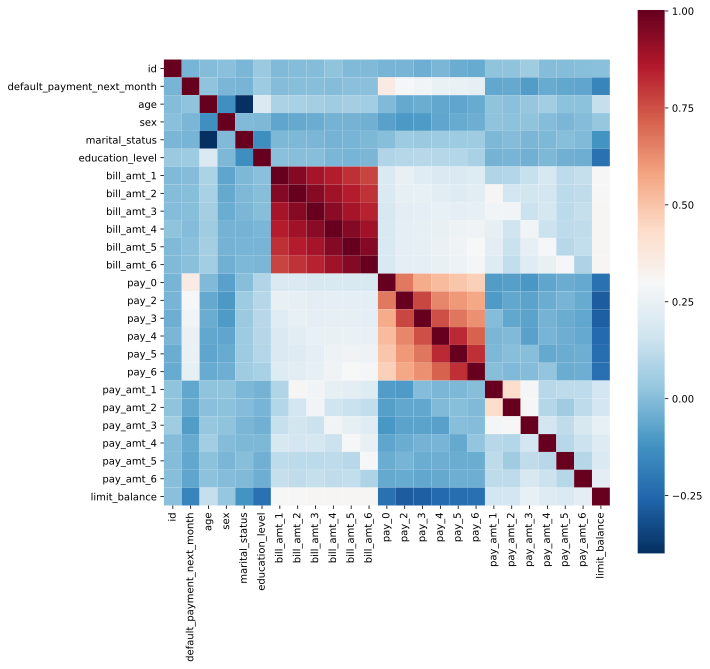

In [23]:
# Plot the correlation matrix
corrs = model_data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrs, square=True, cmap="RdBu_r");
plt.savefig(fname='corr_matrix', dpi=150)

In [25]:
# Use Patsy to create my X Matrix
x_cols = ['my_clusters',
        'id', 'age', 'sex', 'marital_status', 'education_level',  
        'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
        'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
        'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
         'limit_balance']
# Add interactions
x_str = x_cols[0]
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + '' # if I want to create new variables, add in empty string

x_patsy = dmatrix(x_str, model_data)
x_patsy.shape

(2965, 29)

In [26]:
# Shuffle and then train/test split of my variables
# from sklearn.utils import shuffle

# x_raw = x_patsy
# y_raw = model_data['outcome_var']

#x_shuffle, y_shuffle = shuffle(x_raw, y_raw)
#x_mid, x_test, y_mid, y_test = train_test_split(x_shuffle, y_shuffle, test_size=0.2, random_state=0)
#x_train, x_val, y_train, y_val = train_test_split(x_mid, y_mid, test_size=0.25, random_state=0)

# Stratified train test split
x_raw = x_patsy
y_raw = np.array(model_data['default_payment_next_month'])

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss2 = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_mid, x_test = x_raw[train_index,:], x_raw[test_index,:]
    y_mid, y_test = y_raw[train_index], y_raw[test_index]

sss2.get_n_splits()
for train_index, test_index in sss2.split(x_mid, y_mid):
    x_train, x_val = x_mid[train_index,:], x_mid[test_index,:]
    y_train, y_val = y_mid[train_index], y_mid[test_index]

In [27]:
# Normalize my variables
scaler = StandardScaler()
scaler.fit(x_train)
x_norm_train = scaler.transform(x_train)
x_norm_val = scaler.transform(x_val)
x_norm_test = scaler.transform(x_test)

In [28]:
# Run CV with 5 folds (knn)

ks = [10,30,50,100]
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
knn_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    3.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_neighbors': [10, 30, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [29]:
# Run CV with 5 folds (logit)

penalty = ['l2']
C = np.logspace(0, 4, 10, 100, 1000)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1313s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1611s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e+00, 2.15443e+01, 4.64159e+02, 1.00000e+04, 2.15443e+05,
       4.64159e+06, 1.00000e+08, 2.15443e+09, 4.64159e+10, 1.00000e+12]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [31]:
# Run CV with 5 folds (SVM)

C = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 0.1, 1]
param_grid = dict(C=C, gamma=gammas)

svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
svm_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   21.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [32]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(x_norm_train, y_train)

In [ ]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [100, 200, 400, 1000]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

In [ ]:
print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

In [ ]:
print('Best Params for knn: ', knn_grid.best_params_)
print('Best Patams for logit: ', logistic_grid.best_params_)
print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', rf_grid.best_params_)

In [ ]:
# Fit sub_grade Classifier

sub_grade_str = 'sub_grade'
x_patsy_sg = dmatrix(sub_grade_str, model_data)
#x_patsy_sg_test = x_patsy_sg[test_index,:]
x_patsy_sg_val = x_patsy_sg[test_index,:]
x_patsy_sg_train = x_patsy_sg[train_index,:]

logistic_sub_grade = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_sub_grade.fit(x_patsy_sg_train, y_train)
logistic_sub_grade.coef_

In [ ]:
# Fit Dummy Classifier
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(x_norm_train, y_train)

In [ ]:
# ROC for all the models

# model_list = [knn_grid.best_estimator_, 
#               logistic_grid.best_estimator_, 
#               svm_grid.best_estimator_, 
#               gnb_best, 
#               rf_grid.best_estimator_,
#               'ensemble',
#               logistic_sub_grade,
#               dummy]
# model_name = ['knn', 'logit', 'svm', 'n_bayes', 'random_forest', 'ensemble', 'sg_only', 'dummy']

# ROC for just the FASTEST models

# model_list = [logistic_grid.best_estimator_, 
#               gnb_best, 
#               rf_grid.best_estimator_,
#               'ensemble',
#               logistic_sub_grade,
#               dummy]
# model_name = ['logit', 'n_bayes', 'random_forest', 'ensemble', 'sg_only', 'dummy']

# ROC for just the BEST models

model_list = [logistic_grid.best_estimator_,  
              rf_grid.best_estimator_,
              'ensemble',
              logistic_sub_grade,
              dummy]
model_name = ['logit', 'random_forest', 'ensemble', 'sg_only', 'dummy']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.60
        w2 = 0.30
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(x_norm_val)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(x_norm_val)[:,1]
                  + (1-w1-w2)*gnb_best.predict_proba(x_norm_val)[:,1])
        
    elif model == logistic_sub_grade:
        y_pred = list(model.predict_proba(x_patsy_sg_val)[:,1])
    else:
        y_pred = list(model.predict_proba(x_norm_val)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Examine the correlation of the model errors

knn_error = y_train - knn_grid.predict_proba(x_norm_train)[:,1]
logit_error = y_train - logistic_grid.predict_proba(x_norm_train)[:,1]
svm_error = y_train - svm_grid.predict_proba(x_norm_train)[:,1]
gnb_error = y_train - gnb_best.predict_proba(x_norm_train)[:,1]
rf_error = y_train - rf_grid.predict_proba(x_norm_train)[:,1]

error_df = pd.DataFrame()
error_df['knn'] = knn_error
error_df['logit'] = logit_error
error_df['svm'] = svm_error
error_df['gnb'] = gnb_error
error_df['rand_forest'] = rf_error

error_df.corr()